In [1]:

import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
from subprocess import check_output


Using TensorFlow backend.


In [2]:
input_dir  = Path('../input/')
train = input_dir / 'train'
train_cleaned = input_dir / 'train_cleaned'
test = input_dir / 'test'

In [3]:
# The train directory comtaims png files. Let's get all the files and check a few samples
train_images = sorted(os.listdir(train))
train_labels = sorted(os.listdir(train_cleaned))
test_images = sorted(os.listdir(test))
#print(train_images)
#print(train_labels)
sample_imag=imread(train/train_images[0])
imag_shape=sample_imag.shape
print('The shape of an image is '+str(imag_shape))

The shape of an image is (420, 540)


Dirty samples and corresponding cleaned versions in training set:


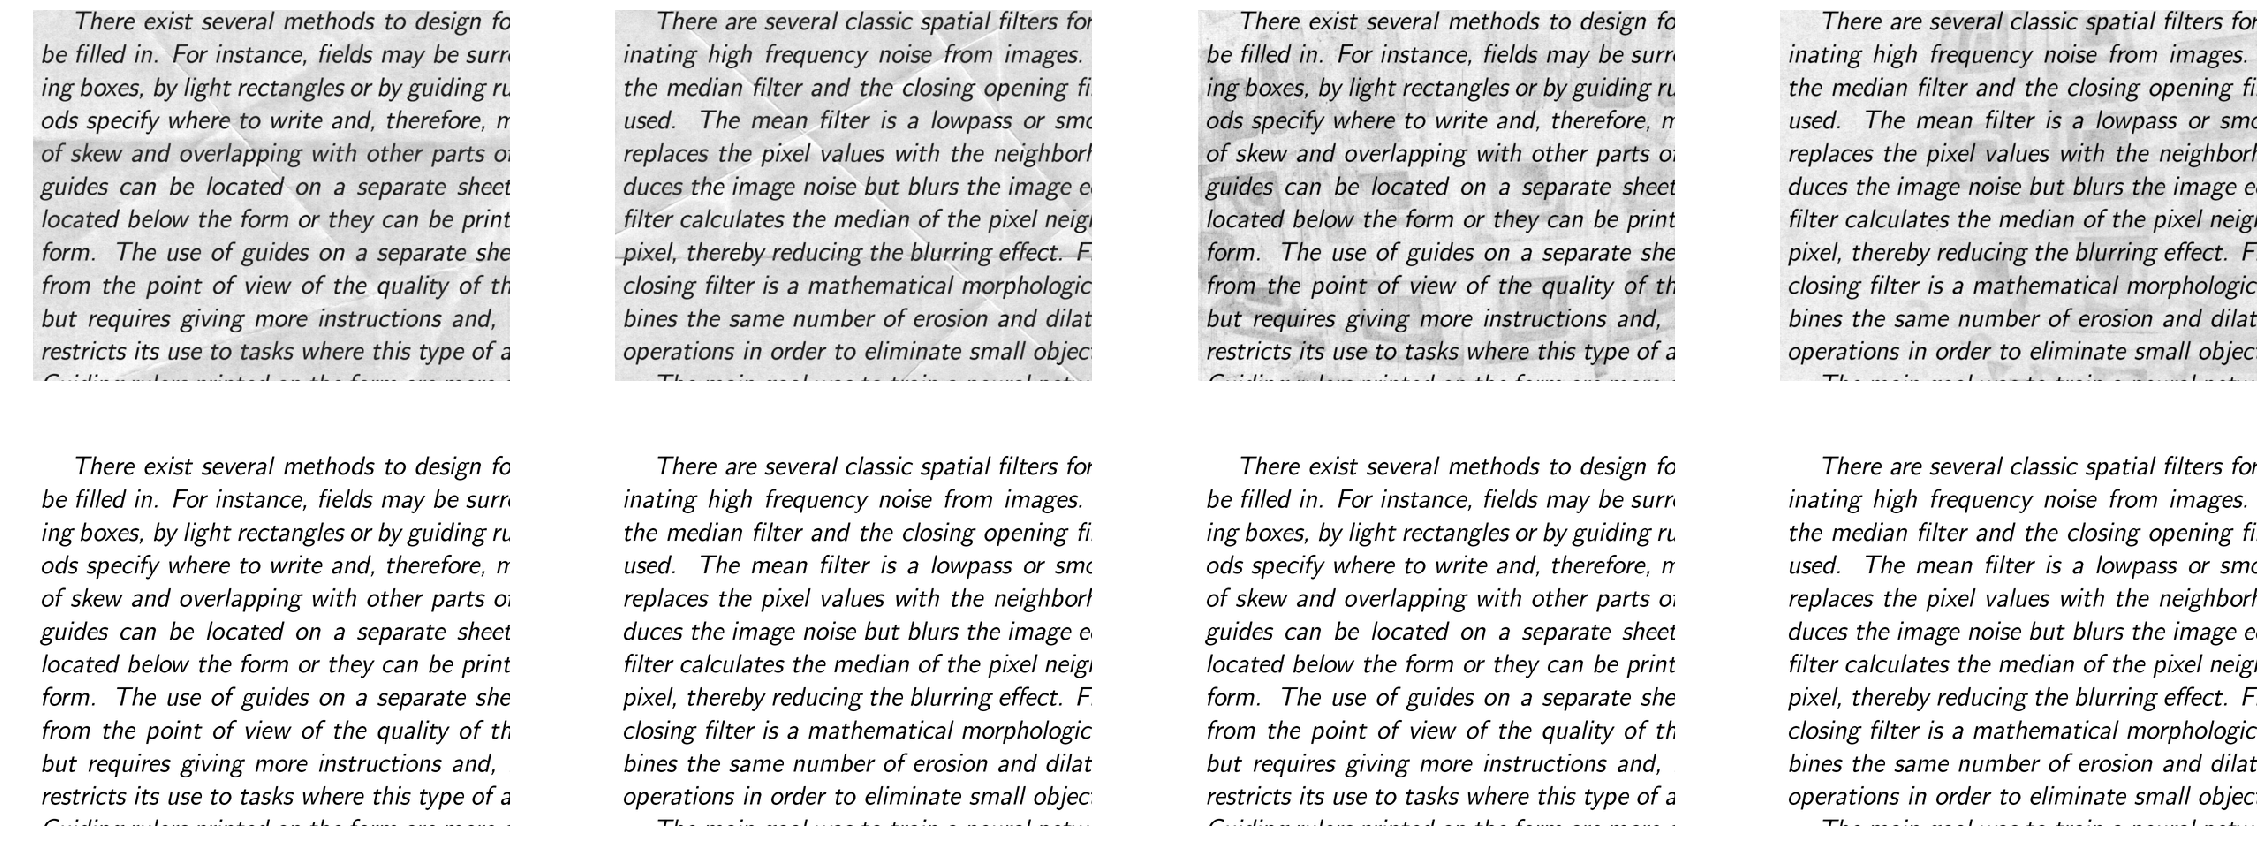

In [4]:
#print out some samples
nsamples=4
samples = train_images[:nsamples]
f, ax = plt.subplots(2, nsamples, figsize=(40,15))
print('Dirty samples and corresponding cleaned versions in training set:')
for i, img in enumerate(samples):
    img = imread(train/img)
    ax[0, i].imshow(img, cmap='gray')
    ax[0, i].axis('off')
samples = train_labels[:nsamples] 
for i, img in enumerate(samples):
    img = imread(train_cleaned/img)
    ax[1, i].imshow(img, cmap='gray')
    ax[1, i].axis('off')
plt.show()  

In [7]:
#build auto-encoder
def build_autoenocder():
    input_img = Input(shape=(imag_shape[0],imag_shape[1],1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

In [8]:
autoencoder = build_autoenocder()
autoencoder.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 64)      18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 105, 135, 64)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 105, 135, 64)      36928     
_________________________________________________________________
ups

The dataset is small, so we can actually store the numpy arrays of images and corresponding cleaned images numpy arrays into two numpy arrays (Ha!! a lot of `numpy` and `array` in a single sentence). This would eliminate the need for defining a generator. 

In [9]:
X = []
Y = []

for img in train_images:
    img = load_img(train / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(train_cleaned / img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [10]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (129, 420, 540, 1)
Total number of validation samples:  (15, 420, 540, 1)


In [12]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))

Train on 129 samples, validate on 15 samples
Epoch 1/20
129/129 [==============================] - 172s 1s/step - loss: 0.3922 - val_loss: 0.3650
Epoch 2/20
129/129 [==============================] - 154s 1s/step - loss: 0.3643 - val_loss: 0.3635
Epoch 3/20
129/129 [==============================] - 152s 1s/step - loss: 0.3526 - val_loss: 0.3610
Epoch 4/20
129/129 [==============================] - 156s 1s/step - loss: 0.3490 - val_loss: 0.3490
Epoch 5/20
129/129 [==============================] - 745s 6s/step - loss: 0.3421 - val_loss: 0.3392
Epoch 6/20
129/129 [==============================] - 213s 2s/step - loss: 0.3295 - val_loss: 0.3239
Epoch 7/20
129/129 [==============================] - 185s 1s/step - loss: 0.3113 - val_loss: 0.2980
Epoch 8/20
129/129 [==============================] - 181s 1s/step - loss: 0.2825 - val_loss: 0.2694
Epoch 9/20
129/129 [==============================] - 175s 1s/step - loss: 0.2588 - val_loss: 0.2581
Epoch 10/20
129/129 [=========================

In [13]:
autoencoder.save_weights('DAE.h5')

In [18]:
X_test = []
for img in test_images:
    img = load_img(test / img, grayscale=True,target_size=imag_shape)
    img = img_to_array(img).astype('float32')/255.
    X_test.append(img)

X_test = np.array(X_test)
print(X_test.shape)

(72, 420, 540, 1)


(72, 420, 540, 1)


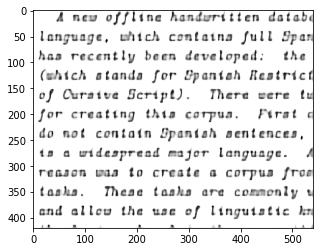

In [19]:
X_dec = autoencoder.predict(X_test)
print(X_dec.shape)

#plt.imshow(np.squeeze(X_test[10]),cmap='gray')
#plt.imshow(np.squeeze(X_dec[10]),cmap='gray')

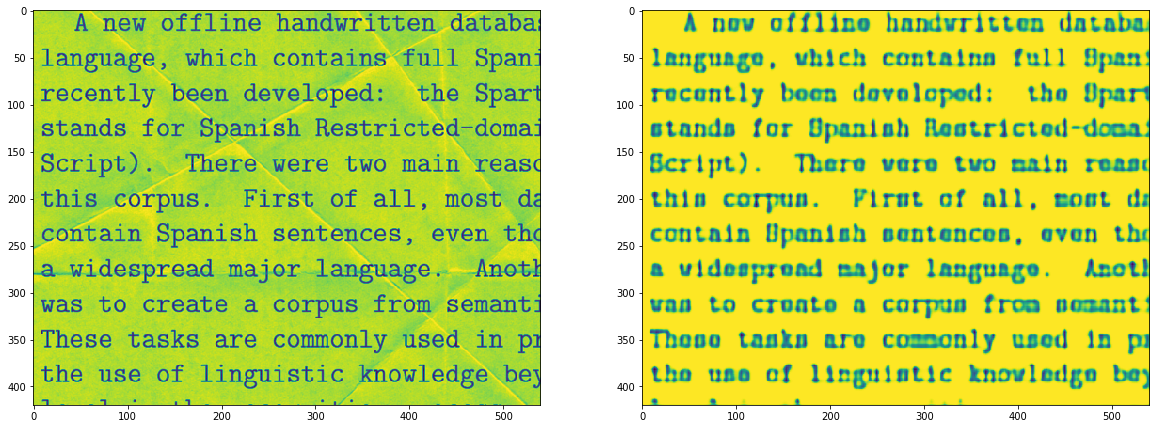

In [28]:
plt.figure(figsize=(20, 40))
plt.subplot(1, 2, 1)
id=15
plt.imshow(np.squeeze(X_test[id]))
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(X_dec[id]))
plt.show()

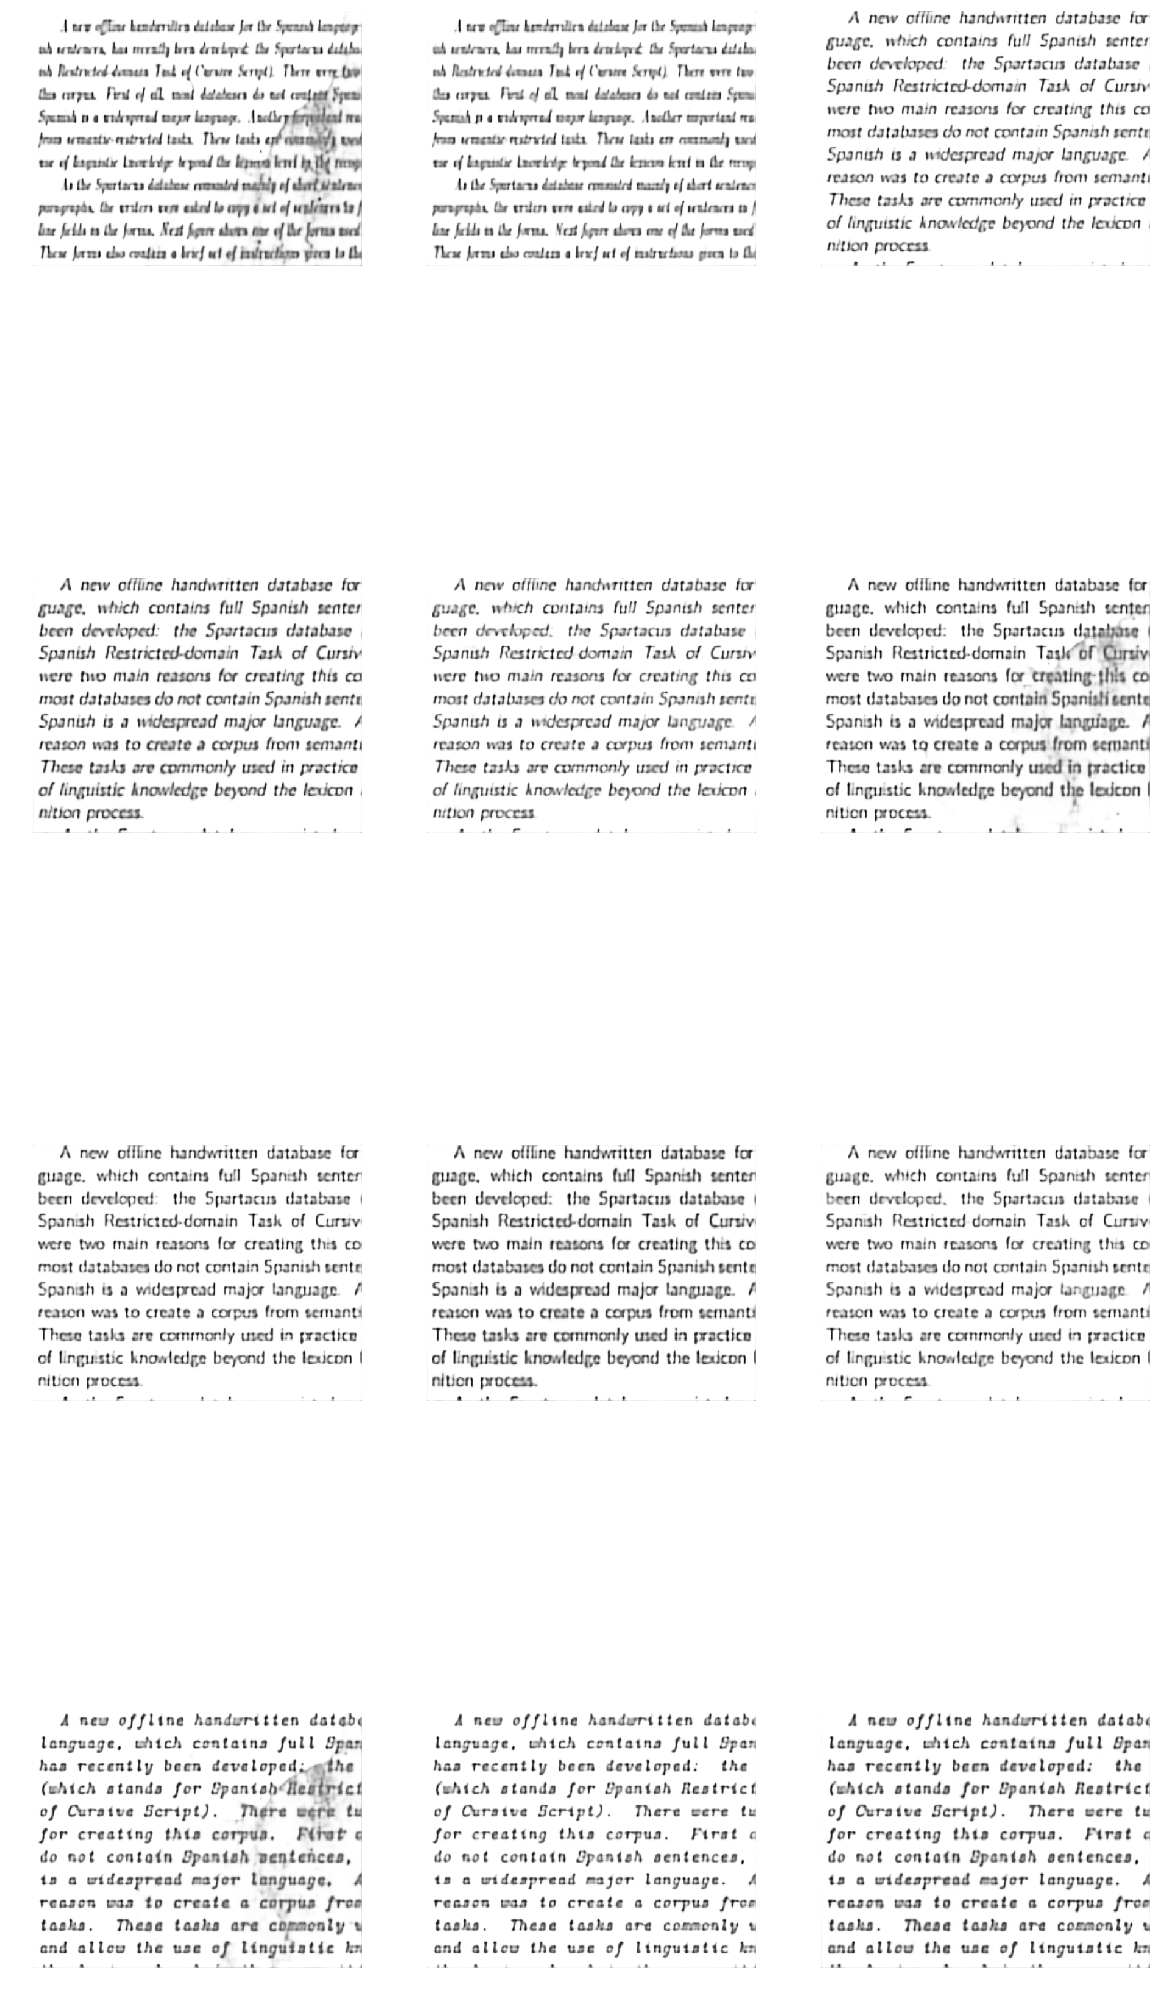

In [26]:
plt.figure(figsize=(20, 40))
num_imags=12
rows=4
cols=int(num_imags/rows)
for i in range(num_imags):
        plt.subplot(rows, cols, i + 1)
        image = np.squeeze(X_dec[i])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    #plt.savefig(filename)